Using device: cuda
Train folder: ['pituitary', 'notumor', 'meningioma', 'glioma']
Test folder: ['pituitary', 'notumor', 'meningioma', 'glioma']
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 | Train Acc: 91.60% | Val Acc: 97.10%
Epoch 2/10 | Train Acc: 97.18% | Val Acc: 97.10%
Epoch 3/10 | Train Acc: 98.62% | Val Acc: 94.74%
Epoch 4/10 | Train Acc: 98.16% | Val Acc: 98.78%
Epoch 5/10 | Train Acc: 98.76% | Val Acc: 98.86%
Epoch 6/10 | Train Acc: 98.81% | Val Acc: 98.86%
Epoch 7/10 | Train Acc: 98.93% | Val Acc: 98.55%
Epoch 8/10 | Train Acc: 99.33% | Val Acc: 98.78%
Epoch 9/10 | Train Acc: 99.60% | Val Acc: 99.31%
Epoch 10/10 | Train Acc: 99.75% | Val Acc: 99.01%


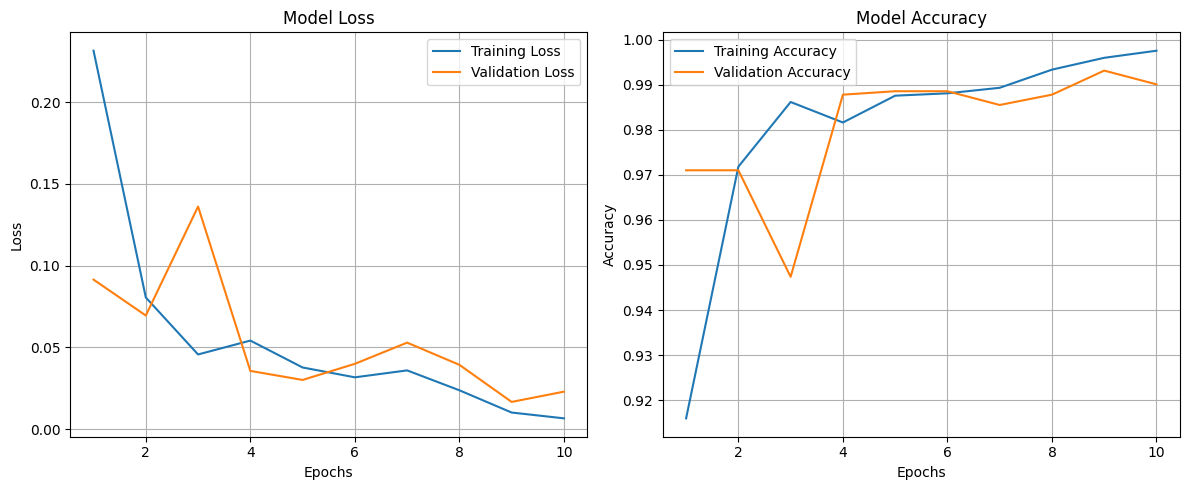


HYPERPARAMETERS
Learning Rate: 3e-05
Batch Size: 16
Hidden Size: 768
Epochs: 10

EVALUATION METRICS
Accuracy (%): 99.31%
Precision (%): 99.32%
Recall (%): 99.31%
F1 Score (%): 99.31%
Cohen's Kappa Score: 0.9908
P-value: 0.000000


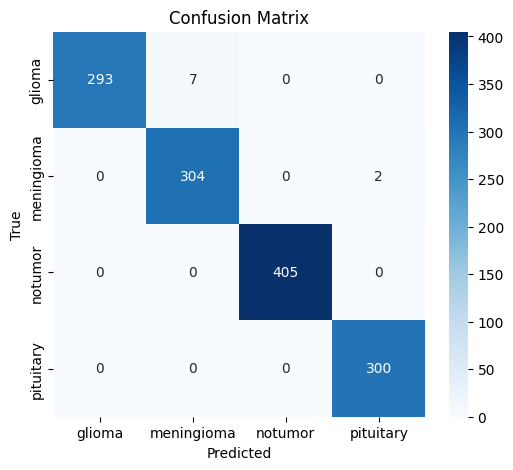


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311


SUMMARY TABLE FORMAT
Learning Rate: 3e-05
Batch Size: 16
Hidden Size: 768
Epochs: 10
Accuracy (%): 99.31%
F1 Score (%): 99.31%
Recall (%): 99.31%
Precision (%): 99.32%
Cohen's Kappa Score: 0.9908
P-value: 0.000000


In [1]:
# ===============================
# Brain Tumor MRI Classification - ViT Fine-tuning
# ===============================

import os, gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import random

# ------------------------------
# 1. Device & Memory Cleanup
# ------------------------------
gc.collect()
torch.cuda.empty_cache()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ------------------------------
# 2. Dataset Paths
# ------------------------------
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"  # Correct path
train_dir = os.path.join(DATA_DIR, "Training")
test_dir  = os.path.join(DATA_DIR, "Testing")

print("Train folder:", os.listdir(train_dir))
print("Test folder:", os.listdir(test_dir))

# ------------------------------
# 3. Transforms (Augmentation)
# ------------------------------
IMG_SIZE = 224
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# ------------------------------
# 4. Load Dataset
# ------------------------------
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)
class_names = train_dataset.classes
print("Classes:", class_names)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# ------------------------------
# 5. Model - Pretrained ViT
# ------------------------------
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=len(class_names))
model.to(DEVICE)

# ------------------------------
# 6. Hyperparameter Logging Setup
# ------------------------------
hyperparameters = {
    "Learning Rate": 3e-5,
    "Batch Size": 16,
    "Hidden Size": 768,  # ViT-Base hidden size
    "Epochs": 10
}

# ------------------------------
# 7. Loss, Optimizer & Scheduler
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters["Learning Rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# ------------------------------
# 8. Training Loop
# ------------------------------
EPOCHS = hyperparameters["Epochs"]
best_acc = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_vit_model.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

# ------------------------------
# 9. Load Best Model
# ------------------------------
model.load_state_dict(torch.load("/kaggle/working/best_vit_model.pth"))

# ------------------------------
# 10. Evaluation
# ------------------------------
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate confusion matrix FIRST
cm = confusion_matrix(y_true, y_pred)

# Calculate comprehensive metrics
test_acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
ck_score = cohen_kappa_score(y_true, y_pred)

# ------------------------------
# 11. P-value Calculation
# ------------------------------
# Calculate p-value using permutation test
def calculate_p_value(y_true, y_pred, n_permutations=1000):
    # Calculate observed accuracy
    observed_accuracy = accuracy_score(y_true, y_pred)
    
    # Create random predictions by shuffling the true labels
    random_accuracies = []
    for _ in range(n_permutations):
        shuffled_preds = y_true.copy()
        random.shuffle(shuffled_preds)
        random_accuracy = accuracy_score(y_true, shuffled_preds)
        random_accuracies.append(random_accuracy)
    
    # Calculate p-value
    p_value = np.mean(np.array(random_accuracies) >= observed_accuracy)
    return p_value

p_value = calculate_p_value(y_true, y_pred)

# ------------------------------
# 12. Training History Visualization
# ------------------------------
# Create figure with two subplots
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accs, label='Training Accuracy')
plt.plot(range(1, EPOCHS+1), val_accs, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# ------------------------------
# 13. Print Results
# ------------------------------
print("\n" + "="*60)
print("HYPERPARAMETERS")
print("="*60)
for k, v in hyperparameters.items():
    print(f"{k}: {v}")

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Accuracy (%): {test_acc*100:.2f}%")
print(f"Precision (%): {precision*100:.2f}%")
print(f"Recall (%): {recall*100:.2f}%")
print(f"F1 Score (%): {f1*100:.2f}%")
print(f"Cohen's Kappa Score: {ck_score:.4f}")
print(f"P-value: {p_value:.6f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# ------------------------------
# 14. Format for Table
# ------------------------------
print("\n" + "="*60)
print("SUMMARY TABLE FORMAT")
print("="*60)
print(f"Learning Rate: {hyperparameters['Learning Rate']}")
print(f"Batch Size: {hyperparameters['Batch Size']}")
print(f"Hidden Size: {hyperparameters['Hidden Size']}")
print(f"Epochs: {hyperparameters['Epochs']}")
print(f"Accuracy (%): {test_acc*100:.2f}%")
print(f"F1 Score (%): {f1*100:.2f}%")
print(f"Recall (%): {recall*100:.2f}%")
print(f"Precision (%): {precision*100:.2f}%")
print(f"Cohen's Kappa Score: {ck_score:.4f}")
print(f"P-value: {p_value:.6f}")